# Multi-label Legal Text Classification for CIA

## Models and Experiments: Baseline Models

In [ ]:
!pip install umap-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv

In [2]:
from zipfile import ZipFile
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from nltk.tokenize import sent_tokenize, word_tokenize
from numpy.linalg import norm
import umap.umap_ as umap

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
import pickle

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.chdir("../..")
os.getcwd()

'/Users/janinedevera/Documents/School/MDS 2021-2023/Thesis/multilabel-legal-text-classification-CIA'

### Preliminaries

Load raw data

In [4]:
# legal text, labeled
text = pd.read_csv("data/01 legal_texts_pipeline_stopwords.csv", index_col=0)
text_labels = pd.read_csv("data/01 legal_texts_with_labels_grouped.csv", index_col=0)

# augmented training set and raw test set
train_df_aug = pd.read_csv("data/01 train_data_augmented.csv", index_col=0)
test_df = pd.read_csv("data/01 test_data.csv", index_col=0)

# definitions
defs = pd.read_csv("data/02 oecd_definitions_stopwords.csv", index_col=0)
defs_grouped = pd.read_csv("data/02 oecd_definitions_stopwords_grouped.csv", index_col=0)

In [5]:
defs_grouped['Main'] = defs_grouped['Main'].replace('D', 'Others')
defs_grouped

,Main,text_clean,length
0,A,limit the number of supplier lead to the risk ...,833
1,B,regul can affect a supplier 's abil to compet ...,781
2,C,regul can affect supplier behaviour by not onl...,459
3,Others,regul sometim limit choic avail to consum for ...,257


In [6]:
train_df_aug.Category_New.value_counts()

B         894
Others    743
C         662
A         624
None      522
Name: Category_New, dtype: int64

### I. Logistic Regression

##### a. TF-IDF

As the first baseline model, check the performance of a logistic regression using the **TF-IDF matrix** of the corpus.

In [7]:
# tf-idf vectorizer
vectorizer = TfidfVectorizer()
dfm = vectorizer.fit_transform(text_labels['text_clean'])
dfm.shape

(1792, 3116)

In [8]:
# split data
l_train_text, l_test_text, l_train_labels, l_test_labels = train_test_split(dfm, text_labels['Category_New'], 
                                                                            random_state=999, 
                                                                            test_size=0.3, 
                                                                            stratify=text_labels['Category_New'])

TF-IDF of augmented training set and test set

In [78]:
dfm_train = vectorizer.fit_transform(train_df_aug['text_clean'])
dfm_test = vectorizer.fit_transform(test_df['text_clean'])

print('train dfm shape: ' + str(dfm_train.shape) + ' | test dfm shape:' + str(dfm_test.shape))

train dfm shape: (3445, 3748) | test dfm shape:(708, 2099)


In [79]:
combined_text = pd.concat([train_df_aug['text_clean'], test_df['text_clean']], axis=0)
vectorizer.fit(combined_text)
dfm_train = vectorizer.transform(train_df_aug['text_clean'])
dfm_test = vectorizer.transform(test_df['text_clean'])

print('train dfm shape: ' + str(dfm_train.shape) + ' | test dfm shape:' + str(dfm_test.shape))

train dfm shape: (3445, 4000) | test dfm shape:(708, 4000)


In [80]:
train_text, train_labels, test_text, test_labels = dfm_train, train_df_aug['Category_New'], dfm_test, test_df['Category_New']

In [81]:
# scale data
scaler = StandardScaler(with_mean=False)
train_text_scaled = scaler.fit_transform(train_text)
test_text_scaled = scaler.transform(test_text)

# train model and return training accuracy
clf = LogisticRegression(random_state=999, max_iter=1000).fit(train_text_scaled, train_labels)
with open('./models/logistic.pkl', 'wb') as f: pickle.dump(clf, f)

train_acc = clf.score(train_text_scaled, train_labels)

# evaluate on test data 
y_pred = clf.predict(test_text_scaled)
classification_rep = classification_report(test_labels, y_pred, zero_division=0)
test_acc = clf.score(test_text_scaled, test_labels)

# print classification report
print(' Classification Report:')
print(classification_rep)
print('Train vs Test Accuracy:')
print('Train:' + str(round(train_acc, 3)))
print('Test:' + str(round(test_acc, 3)))

 Classification Report:
              precision    recall  f1-score   support

           A       0.86      0.80      0.83       376
           B       0.37      0.51      0.43        68
           C       0.38      0.56      0.45        18
        None       0.92      0.81      0.86       225
      Others       0.17      0.29      0.21        21

    accuracy                           0.76       708
   macro avg       0.54      0.59      0.56       708
weighted avg       0.80      0.76      0.77       708

Train vs Test Accuracy:
Train:0.972
Test:0.756


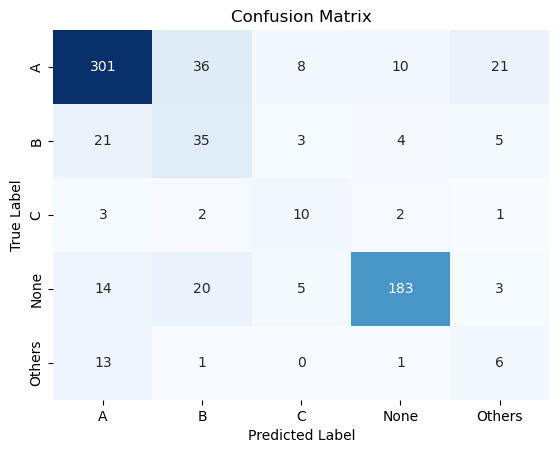

In [82]:
cm = confusion_matrix(test_labels, y_pred)

# plot heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [83]:
# generate classification report
report = classification_report(test_labels, y_pred, zero_division=0, output_dict=True)

# extract precision, recall, and f1-score for each category
categories = ['A', 'B', 'C', 'Others', 'None']
metrics = ['precision', 'recall', 'f1-score']
data = []
for category in categories:
    row = []
    for metric in metrics:
        row.append(round(report[category][metric], 2))
    data.append(row)

# create dataframe
report_df = pd.DataFrame(data, columns=metrics, index=categories)

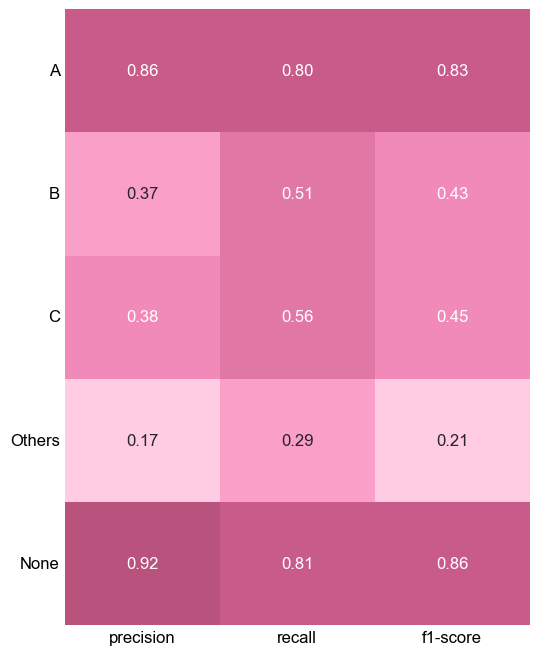

In [84]:
custom_cmap_blues = sns.color_palette(['#A9BBD3', '#A0B4CF', '#8FA8C6', '#7E9CBD', '#6D8FB4', '#537CA6', '#416F9D', '#306294', '#0F4A82'])
custom_cmap_pinks = sns.color_palette(['#FFE6F2', '#FFCCE4', '#F99FC8', '#F28AB9', '#E177A5', '#D56997', '#C85B89', '#B9537E'])

plt.figure(figsize=(6, 8))
sns.heatmap(report_df, annot=True, cmap=custom_cmap_pinks, cbar=False, vmin=0, vmax=1,  fmt='.2f',
            annot_kws={"fontfamily": "Arial", "fontsize": 12})
#plt.xlabel('Metrics', labelpad=12, fontname='Arial', fontsize=12)
#plt.title('Classification report', fontname='Arial', fontsize=14, y=1.02)
plt.xticks(fontname='Arial', fontsize=12)
plt.yticks(fontname='Arial', fontsize=12, rotation=0)
plt.tick_params(axis='y', length=0)
plt.tick_params(axis='x', length=0)

# save the figure
save_path = os.path.join('draft', 'images', 'plot05-01.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

##### b. Bi-grams TF-IDF

This is also compared with a logistic regression using a **tri-gram TF-IDF matrix**, which gives all the possible combinations of 3 words. 

In [96]:
word_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', sublinear_tf=True, strip_accents='unicode', 
                                  stop_words='english', ngram_range=(2, 5))

In [97]:
dfm_train = word_vectorizer.fit_transform(train_df_aug['text_clean'])
dfm_test = word_vectorizer.fit_transform(test_df['text_clean'])

print('train dfm shape: ' + str(dfm_train.shape) + ' | test dfm shape:' + str(dfm_test.shape))

train dfm shape: (3445, 133563) | test dfm shape:(708, 35467)


In [98]:
combined_text = pd.concat([train_df_aug['text_clean'], test_df['text_clean']], axis=0)
word_vectorizer.fit(combined_text)
dfm_train = word_vectorizer.transform(train_df_aug['text_clean'])
dfm_test = word_vectorizer.transform(test_df['text_clean'])

print('train dfm shape: ' + str(dfm_train.shape) + ' | test dfm shape:' + str(dfm_test.shape))

train dfm shape: (3445, 152823) | test dfm shape:(708, 152823)


In [99]:
train_text, train_labels, test_text, text_labels = dfm_train, train_df_aug['Category_New'], dfm_test, test_df['Category_New']

In [100]:
# scale data
scaler = StandardScaler(with_mean=False)
train_text_scaled = scaler.fit_transform(train_text)
test_text_scaled = scaler.transform(test_text)

# train model and return training accuracy
clf = LogisticRegression(random_state=111, max_iter=1000).fit(train_text_scaled, train_labels)
with open('./models/logistic.pkl', 'wb') as f: pickle.dump(clf, f)

train_acc = clf.score(train_text_scaled, train_labels)

# evaluate on test data 
y_pred = clf.predict(test_text_scaled)
classification_rep = classification_report(text_labels, y_pred, zero_division=0)
test_acc = clf.score(test_text_scaled, text_labels)

# print classification report
print(' Classification Report:')
print(classification_rep)
print('Train vs Test Accuracy:')
print('Train:' + str(round(train_acc, 3)))
print('Test:' + str(round(test_acc, 3)))

# get feature names from vocabulary of vectorizer
feature_names = word_vectorizer.get_feature_names_out()

# calculate feature importance
importance = clf.coef_[0]
feature_importance = abs(importance)
sorted_idx = feature_importance.argsort()[::-1]

# print top 20 important features (tri-grams)
print('Top 20 Important Bi-grams:')
for i, idx in enumerate(sorted_idx[:20]):
    print(f"{i+1}. Bi-gram: {feature_names[idx]}, Importance: {feature_importance[idx]}")

 Classification Report:
              precision    recall  f1-score   support

           A       0.89      0.74      0.81       376
           B       0.25      0.68      0.36        68
           C       0.44      0.39      0.41        18
        None       0.97      0.74      0.84       225
      Others       0.18      0.19      0.19        21

    accuracy                           0.71       708
   macro avg       0.55      0.55      0.52       708
weighted avg       0.82      0.71      0.75       708

Train vs Test Accuracy:
Train:0.968
Test:0.708
Top 20 Important Bi-grams:
1. Bi-gram: thi linkag, Importance: 0.10441458971093738
2. Bi-gram: concern livestock, Importance: 0.10441458971093738
3. Bi-gram: p 79, Importance: 0.10441458971093738
4. Bi-gram: vote right, Importance: 0.10441458971093738
5. Bi-gram: farm product, Importance: 0.10441458971093738
6. Bi-gram: oris school, Importance: 0.10441458971093738
7. Bi-gram: ass offer, Importance: 0.09396799713927106
8. Bi-gram: domest

In [46]:
# generate classification report
report = classification_report(test_labels, y_pred, zero_division=0, output_dict=True)

# extract precision, recall, and f1-score for each category
categories = ['A', 'B', 'C', 'Others', 'None']
metrics = ['precision', 'recall', 'f1-score']
data = []
for category in categories:
    row = []
    for metric in metrics:
        row.append(round(report[category][metric], 2))
    data.append(row)

# create dataframe
report_df = pd.DataFrame(data, columns=metrics, index=categories)

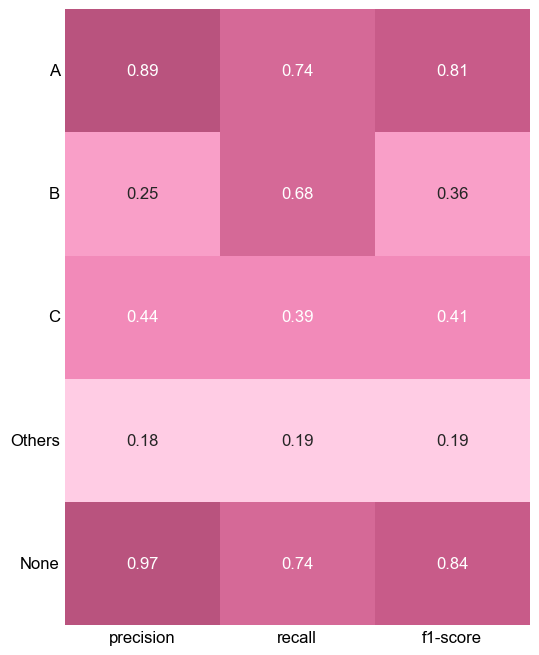

In [50]:
plt.figure(figsize=(6, 8))
sns.heatmap(report_df, annot=True, cmap=custom_cmap_pinks, cbar=False, vmin=0, vmax=1,  fmt='.2f',
            annot_kws={"fontfamily": "Arial", "fontsize": 12})
#plt.xlabel('Metrics', labelpad=12, fontname='Arial', fontsize=12)
#plt.title('Classification report', fontname='Arial', fontsize=14, y=1.02)
plt.xticks(fontname='Arial', fontsize=12)
plt.yticks(fontname='Arial', fontsize=12, rotation=0)
plt.tick_params(axis='y', length=0)
plt.tick_params(axis='x', length=0)

# save the figure
save_path = os.path.join('draft', 'images', 'plot05-02.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

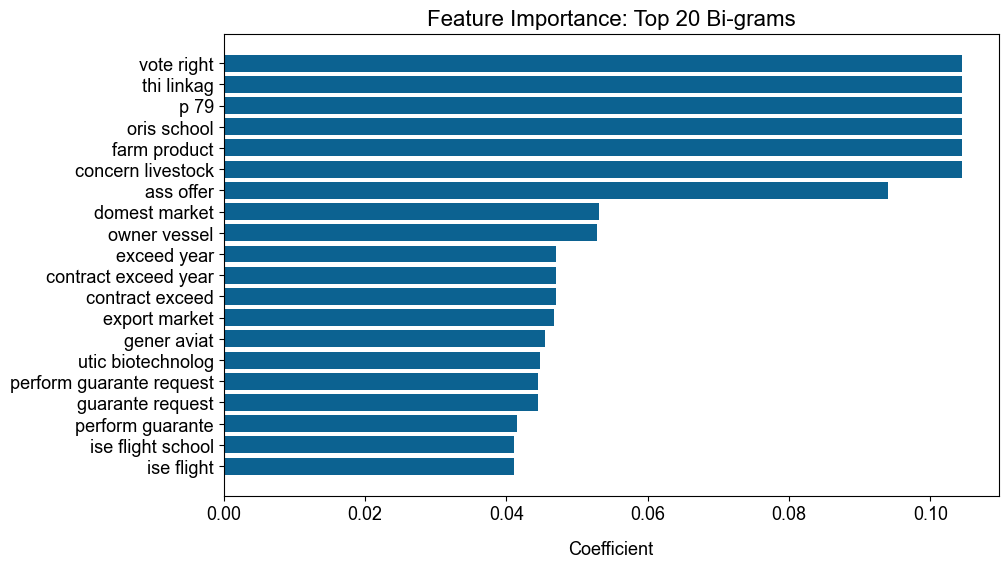

In [52]:
# sort features by importance in descending order
sorted_importance = sorted(zip(feature_importance, feature_names), reverse=True)

# select top n features to display
n_features = 20
top_n_importance = sorted_importance[:n_features]

# extract feature names and importance values
top_n_features = [f[1] for f in top_n_importance]
top_n_values = [f[0] for f in top_n_importance]

# create bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(n_features), top_n_values, align='center', color='#0C6291')
plt.yticks(range(n_features), top_n_features)
plt.xlabel('Coefficient', labelpad=12, fontname='Arial', fontsize=13)
plt.title('Feature Importance: Top 20 Bi-grams', fontname='Arial', fontsize=16)
plt.xticks(fontname='Arial', fontsize=13)
plt.yticks(fontname='Arial', fontsize=13)
plt.gca().invert_yaxis()
plt.show()


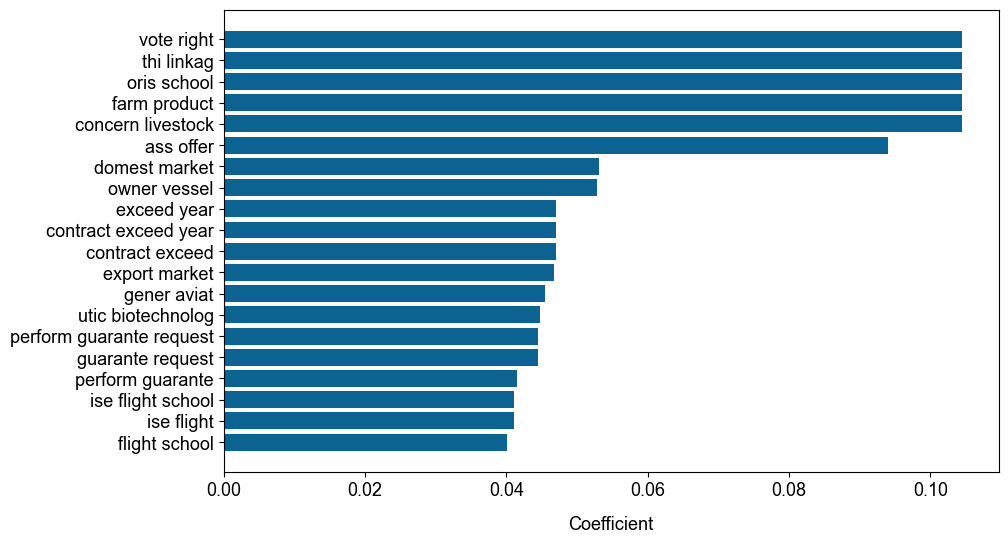

In [54]:
# sort features by importance in descending order
sorted_importance = sorted(zip(feature_importance, feature_names), reverse=True)

# remove 'p 79' and replace with next highest feature
for i, f in enumerate(sorted_importance):
    if f[1] == 'p 79':
        sorted_importance.pop(i)
        sorted_importance.append(sorted_importance[i])

# select top n features to display
n_features = 20
top_n_importance = sorted_importance[:n_features]

# extract feature names and importance values
top_n_features = [f[1] for f in top_n_importance]
top_n_values = [f[0] for f in top_n_importance]

# create bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(n_features), top_n_values, align='center', color='#0C6291')
plt.yticks(range(n_features), top_n_features)
plt.xlabel('Coefficient', labelpad=12, fontname='Arial', fontsize=13)
#plt.title('Feature Importance: Top 20 Feature', fontname='Arial', fontsize=16)
plt.xticks(fontname='Arial', fontsize=13)
plt.yticks(fontname='Arial', fontsize=13)
plt.gca().invert_yaxis()

# save the figure
save_path = os.path.join('draft', 'images', 'plot05-03.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()


Performance of TF-IDF and tri-gram TF-IDF models do not vary significantly. Training accuracy is at around 90% while testing accuracy is at around 86%. In most categories (with meaningful number of observations) recall is higher than precision, which means that the model performs better on minimizing false negatives than false positives.

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

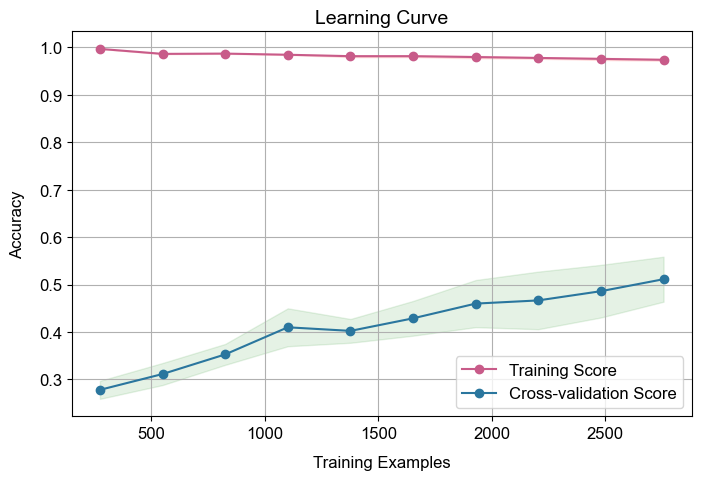

In [72]:
# function for learning curve
def plot_learning_curve(estimator, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.title('Learning Curve', fontname='Arial', fontsize=14)
    plt.xlabel('Training Examples', fontname= 'Arial', fontsize=12, labelpad=10)
    plt.ylabel('Accuracy', fontname='Arial', fontsize=12, labelpad=10)
    plt.xticks(fontname='Arial', fontsize=12)
    plt.yticks(fontname='Arial', fontsize=12)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='#C85B89',
             label='Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='#2A769E',
             label='Cross-validation Score')
    plt.legend(loc='best', prop={'family': 'Arial', 'size': 12})
    plt.show()

# plot learning curve
plot_learning_curve(clf, train_text_scaled, train_labels, cv=5)


However, the learning curves show that the training accuracy is consistently higher than the test accuracy, with the latter showing no furter improvement despite the increase in number of observations. This could be an indication that the model is overfitting to the training data. The small dataset also makes it more likely that the model is overfitting.

### II. GloVe

As an alternative, pre-trained word embeddings can be used to represent the corpus by averaging word vectors using the TF-IDF matrix. From here, similarity scores are obtained between legal texts and the definitions of 4 competition restrictions.

##### a. Document embedding matrix

In [56]:
# load GloVe embeddings
dims = 300
f = open(f'data/glove/glove.6B.{dims}d.txt') # download GloVe and save in data folder

embed_matrix = pd.read_table(
    f, sep = " ", index_col = 0, 
    header = None, quoting = csv.QUOTE_NONE
)

embed_matrix.shape

(400000, 300)

In [282]:
# function for doc embeddings
def doc_embed(df, vectorizer):
    dfm = vectorizer.fit_transform(df['text_clean'])
    common_features = set(embed_matrix.index) & set(vectorizer.get_feature_names_out())
    vocab_ids = [vectorizer.vocabulary_[x] for x in common_features]
    matrix = dfm[:,vocab_ids].dot(embed_matrix.loc[common_features,])
    return matrix

In [283]:
vectorizer = TfidfVectorizer()
countvectorizer = CountVectorizer()

In [285]:
# doc embeddings for legal text
text_labels_embed = doc_embed(train_df_aug, vectorizer)
text_labels_embed.shape

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_6373/2389357900.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  matrix = dfm[:,vocab_ids].dot(embed_matrix.loc[common_features,])


(3445, 300)

In [241]:
# doc embeddings for grouped labels
defs_grouped_embed = doc_embed(defs_grouped, vectorizer)
defs_grouped_embed.shape

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_6373/2389357900.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  matrix = dfm[:,vocab_ids].dot(embed_matrix.loc[common_features,])


(4, 300)

##### b. Cosine similarities

In [242]:
def cos_sim(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

In [243]:
docs = []
for i in range(len(text_labels_embed)):
    scores = []
    for j in range(len(defs_grouped_embed)):
        A = text_labels_embed[i]
        B = defs_grouped_embed[j]
        scores += [(cos_sim(A,B)+1)/(1+1)] # centered 
    docs += [scores]

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_6373/883174373.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return dot_product / (norm_a * norm_b)


In [244]:
scores_df = pd.DataFrame(docs, columns = ["A", "B", "C", "Others"])
scores_df.head()

,A,B,C,Others
0,0.932245,0.931000,0.921779,0.937238
1,0.930241,0.927452,0.925768,0.922400
2,0.929012,0.934949,0.925709,0.927943
3,0.875265,0.872644,0.866788,0.876923
4,0.932126,0.927128,0.926932,0.926261


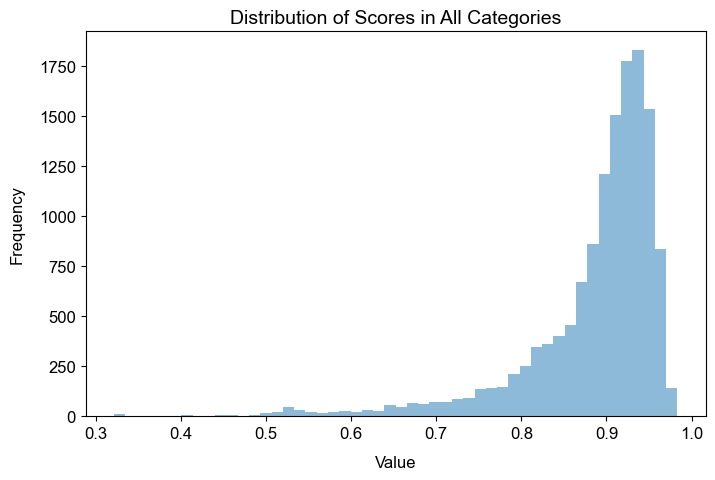

In [245]:
plt.figure(figsize=(8, 5))
plt.hist(scores_df.values.flatten(), bins=50, alpha=0.5, fill='#0C6291')
plt.xlabel('Value', fontname='Arial', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontname='Arial', fontsize=12, labelpad=10)
plt.title('Distribution of Scores in All Categories', fontname='Arial', fontsize=14)
plt.xticks(fontname='Arial', fontsize=12)
plt.yticks(fontname='Arial', fontsize=12)
plt.show()

In [246]:
# df with scores
text_scores_labels_glove = pd.merge(train_df_aug, scores_df, left_index=True, right_index=True)
text_scores_labels_glove.to_csv("data/scores/01 sim_scores_glove_labeled.csv")

##### c. Threshold test

In [247]:
text_scores_labels_glove = pd.read_csv("data/scores/01 sim_scores_glove_labeled.csv", index_col=0)

In [248]:
df_long = pd.melt(text_scores_labels_glove, id_vars=['Law', 'Text', 'Category',  'Category_New', 'text_clean'], 
                  var_name='Predict_Label', value_name='Score') #scores df to long format 
df_long.head()

,Law,Text,Category,Category_New,text_clean,Predict_Label,Score
0,Ordinance NORMAM 12 by DPC-Pilotage,The minimum number of pilotage runs per semest...,A,A,the minimum number of pilotag run per semest c...,A,0.932245
1,"NOM-026-Z00- 1994, Características y especific...",Establishments subjected to this norm (I.e. th...,A,A,establish subject to thi norm i.e those that m...,A,0.930241
2,"NOM-059-Z00- 1997, Salud animal. Especificaciones",The norm specifically states that it is not in...,A,A,the norm specif state that it is not in line w...,A,0.929012
3,Law 13475/2017 - Aeronaut profession,Duty period limitations for flight and cabin c...,A,A,duti period limit for flight and cabin crew of...,A,0.875265
4,Law 7565/1986 - Brazilian Aeronautical Code,The responsible party that pays the indemnity ...,None,None,the respons parti that pay the indemn is exone...,A,0.932126


Since the distribution of the scores is skewed to the right, the threshold also has to be set high.

In [249]:
results_multiclass = df_long 
results_multiclass['Predict'] = np.where(results_multiclass['Score'] > 0.90, results_multiclass['Predict_Label'], 'None') #set threshold
results_multiclass[['Law', 'Text', 'text_clean', 'Score', 'Category_New', 'Predict']].drop_duplicates()

,Law,Text,text_clean,Score,Category_New,Predict
0,Ordinance NORMAM 12 by DPC-Pilotage,The minimum number of pilotage runs per semest...,the minimum number of pilotag run per semest c...,0.932245,A,A
1,"NOM-026-Z00- 1994, Características y especific...",Establishments subjected to this norm (I.e. th...,establish subject to thi norm i.e those that m...,0.930241,A,A
2,"NOM-059-Z00- 1997, Salud animal. Especificaciones",The norm specifically states that it is not in...,the norm specif state that it is not in line w...,0.929012,A,A
3,Law 13475/2017 - Aeronaut profession,Duty period limitations for flight and cabin c...,duti period limit for flight and cabin crew of...,0.875265,A,None
4,Law 7565/1986 - Brazilian Aeronautical Code,The responsible party that pays the indemnity ...,the respons parti that pay the indemn is exone...,0.932126,None,A
...,...,...,...,...,...,...
12371,Resolution 302/2014 by National Civil Aviation...,Access to the areas mentioned in this article ...,access to the area mention in thi articl will ...,0.668793,None,None
12372,Acuerdo por el que se determinan los lineamien...,"For prescriptions of antibiotics, pharmacies m...",for prescript of antibiot pharmaci must regist...,0.628552,C,None
12373,Acuerdo por el que se determinan los lineamien...,"With regard to antibiotic prescriptions, pharm...",with regard to antibiot prescript pharmaci mus...,0.771057,C,None
12374,Acuerdo por el que se determinan los lineamien...,"For the administration of antibiotics, pharmac...",for the administr of antibiot pharmaci should ...,0.724180,C,None


The similarity method using GloVe embeddings does not perform as well as the logistic regression.

In [250]:
report = classification_report(results_multiclass['Category_New'], results_multiclass['Predict'])
print(report)

              precision    recall  f1-score   support

           A       0.18      0.15      0.16      2332
           B       0.27      0.15      0.20      3168
           C       0.19      0.15      0.16      2328
        None       0.16      0.45      0.24      1844
      Others       0.22      0.14      0.17      2704

    accuracy                           0.19     12376
   macro avg       0.20      0.21      0.19     12376
weighted avg       0.21      0.19      0.18     12376



In [252]:
# generate classification report
report = classification_report(results_multiclass['Category_New'], results_multiclass['Predict'], zero_division=0, output_dict=True)

# extract precision, recall, and f1-score for each category
categories = ['A', 'B', 'C', 'Others', 'None']
metrics = ['precision', 'recall', 'f1-score']
data = []
for category in categories:
    row = []
    for metric in metrics:
        row.append(round(report[category][metric], 2))
    data.append(row)

# create dataframe
report_df = pd.DataFrame(data, columns=metrics, index=categories)

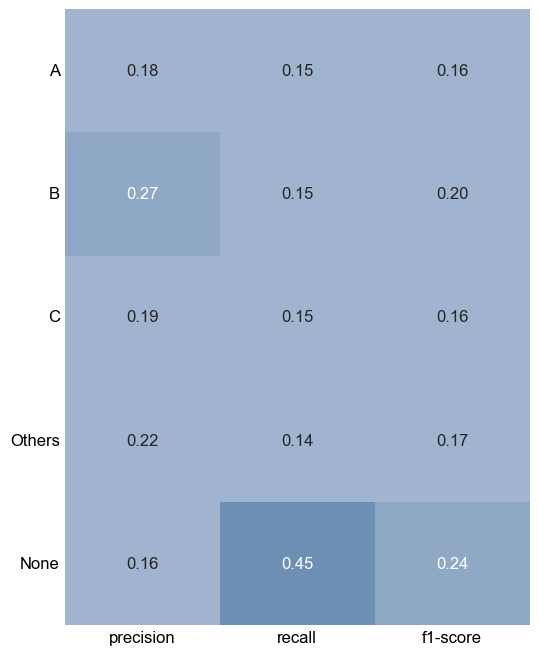

In [253]:
plt.figure(figsize=(6, 8))
sns.heatmap(report_df, annot=True, cmap=custom_cmap_blues, cbar=False, vmin=0, vmax=1,  fmt='.2f',
            annot_kws={"fontfamily": "Arial", "fontsize": 12})
#plt.xlabel('Metrics', labelpad=12, fontname='Arial', fontsize=12)
#plt.title('Classification report', fontname='Arial', fontsize=14, y=1.02)
plt.xticks(fontname='Arial', fontsize=12)
plt.yticks(fontname='Arial', fontsize=12, rotation=0)
plt.tick_params(axis='y', length=0)
plt.tick_params(axis='x', length=0)
plt.show()

##### d. Binary threshold test

All categories can also be grouped as "Yes" (i.e. with potential restrictions) to test if the similarity method performs better if applied to a binary classification task. 

In [103]:
results_binary = df_long 
results_max_score = results_binary.groupby('Text')['Score'].max() #get the highest score among 4 categories
results_final = pd.merge(results_binary, results_max_score, on=['Text', 'Score'])

results_final['Predict'] = np.where(results_final['Score'] > 0.90, 'Yes', 'None') #if max score of highest category is above 0.95, predicted label = yes
results_final['Category_New'] = np.where(results_final['Category_New'] == 'None', results_final['Category_New'], 'Yes') #all categories changed to 'yes' except none

In [104]:
report = classification_report(results_final['Category_New'], results_final['Predict'])
print(report)

              precision    recall  f1-score   support

        None       0.17      0.41      0.24       473
         Yes       0.85      0.63      0.73      2587

    accuracy                           0.60      3060
   macro avg       0.51      0.52      0.48      3060
weighted avg       0.75      0.60      0.65      3060



As a binary classification problem, the similarity method performs slightly better. Recall is high for the Yes category, but overall accuracy is only at 54%.

##### e. Dimensionality reduction

Augmented data

In [105]:
# df combining text and labels
df_comb = (text_scores_labels_glove[['Law', 'text_clean', 'Category_New']]
           .rename(columns = {'Law':'name'})
           .append(defs_grouped[['Main', 'text_clean']]
                   .rename(columns = {'Main':'name'})))
df_comb.head()

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_6373/1632365060.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_comb = (text_scores_labels_glove[['Law', 'text_clean', 'Category_New']]


,name,text_clean,Category_New
0,Ordinance NORMAM 12 by DPC-Pilotage,the minimum number of pilotag run per semest c...,A
1,"NOM-026-Z00- 1994, Características y especific...",establish subject to thi norm i.e those that m...,A
2,"NOM-059-Z00- 1997, Salud animal. Especificaciones",the norm specif state that it is not in line w...,A
3,Law 13475/2017 - Aeronaut profession,duti period limit for flight and cabin crew of...,A
4,Law 7565/1986 - Brazilian Aeronautical Code,the respons parti that pay the indemn is exone...,None


In [106]:
reducer = umap.UMAP()

# dfm combining embeddings 
def dfm_combined(df, dfm1, dfm2):
    dfm_comb = np.vstack((dfm1, dfm2))
    embed = reducer.fit_transform(dfm_comb)
    df["x"] = embed[:,0]
    df["y"] = embed[:,1]
    return df

In [ ]:
dfm_reduced = dfm_combined(df_comb, text_labels_embed, defs_grouped_embed)

In [299]:
dfm_reduced.to_csv("data/scores/02 sim_scores_dim_reduced_glove.csv")

Labeled data (not augmented)

In [291]:
text_labels_embed_nonaug = doc_embed(text_labels, vectorizer)
text_labels_embed_nonaug.shape

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_6373/2389357900.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  matrix = dfm[:,vocab_ids].dot(embed_matrix.loc[common_features,])


(1792, 300)

In [292]:
embed = reducer.fit_transform(text_labels_embed_nonaug)
text_labels["x"] = embed[:,0]
text_labels["y"] = embed[:,1]

In [295]:
text_labels.to_csv("data/03 word_embed_glove.csv")

### III. Legal Word2Vec

The same method as GloVe similarity scores is applied but using Word2Vec embeddings trained from a legal corpus. 

##### a. Document embedding matrix (from SigmaLaw word2vec trained from legal corpus)

In [86]:
w2v_law = KeyedVectors.load_word2vec_format("data/sigma-lemmatized-legal/legallemmatextreplacewithnnp.bin", binary=True, unicode_errors='ignore') 
w2v_law.vectors.shape

(52431, 200)

In [87]:
def doc_matrix_w2v(dfm):
    words = set(vectorizer.get_feature_names_out())
    text_vocab = list(words)

    common_features = []
    for word in text_vocab:
        if word in w2v_law:
            common_features += [word]

    embed_common=np.empty((0,200))
    for word in words:
        if word in w2v_law:
            embed_common=np.vstack([embed_common, w2v_law[word]])

    vocab_ids = [vectorizer.vocabulary_[x] for x in common_features]
    doc_matrix_w2v = dfm[:,vocab_ids].dot(embed_common)

    return doc_matrix_w2v
    

In [88]:
text_dfm = vectorizer.fit_transform(train_df_aug['text_clean'])
text_doc_matrix = doc_matrix_w2v(text_dfm)
text_doc_matrix.shape

(3445, 200)

In [257]:
defs_dfm = vectorizer.fit_transform(defs_grouped['text_clean'])
defs_doc_matrix = doc_matrix_w2v(defs_dfm)
defs_doc_matrix.shape

(4, 200)

##### b. Cosine similarities

In [258]:
docs = []
for i in range(len(text_doc_matrix)):
    scores = []
    for j in range(len(defs_doc_matrix)):
        A = text_doc_matrix[i]
        B = defs_doc_matrix[j]
        scores += [(cos_sim(A,B)+1)/(1+1)] # centered 
    docs += [scores]

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_6373/883174373.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return dot_product / (norm_a * norm_b)


In [259]:
scores_df = pd.DataFrame(docs, columns = ["A", "B", "C", "Others"])
scores_df.head()

,A,B,C,Others
0,0.580615,0.617484,0.585379,0.666514
1,0.670425,0.716627,0.716724,0.668462
2,0.684419,0.738128,0.729582,0.704757
3,0.600209,0.605134,0.604353,0.631238
4,0.710902,0.706493,0.700326,0.724689


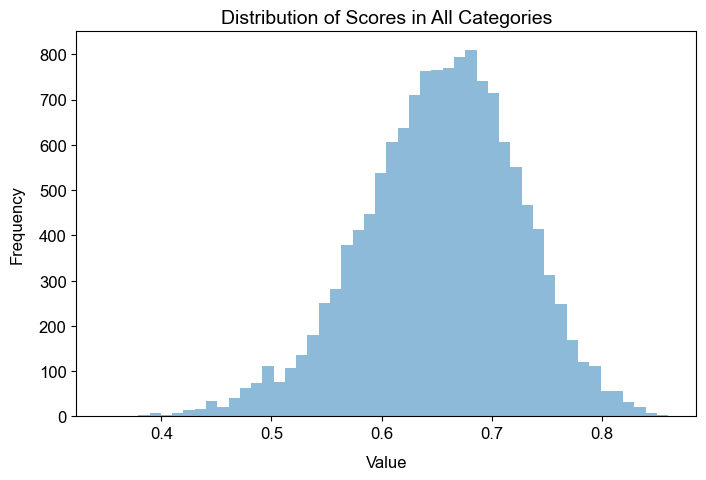

In [260]:
plt.figure(figsize=(8, 5))
plt.hist(scores_df.values.flatten(), bins=50, alpha=0.5, fill='#0C6291')
plt.xlabel('Value', fontname='Arial', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontname='Arial', fontsize=12, labelpad=10)
plt.title('Distribution of Scores in All Categories', fontname='Arial', fontsize=14)
plt.xticks(fontname='Arial', fontsize=12)
plt.yticks(fontname='Arial', fontsize=12)
plt.show()

In [261]:
# df with scores
text_scores_legalw2v = pd.merge(train_df_aug, scores_df, left_index=True, right_index=True)
text_scores_legalw2v.to_csv("data/scores/01 sim_scores_legalw2v_labeled.csv")

##### c. Threshold test

In [262]:
df_long = pd.melt(text_scores_legalw2v, id_vars=['Law', 'Text', 'Category',  'Category_New', 'text_clean'], 
                  var_name='Predict_Label', value_name='Score') #scores df to long format 
df_long.head()

,Law,Text,Category,Category_New,text_clean,Predict_Label,Score
0,Ordinance NORMAM 12 by DPC-Pilotage,The minimum number of pilotage runs per semest...,A,A,the minimum number of pilotag run per semest c...,A,0.580615
1,"NOM-026-Z00- 1994, Características y especific...",Establishments subjected to this norm (I.e. th...,A,A,establish subject to thi norm i.e those that m...,A,0.670425
2,"NOM-059-Z00- 1997, Salud animal. Especificaciones",The norm specifically states that it is not in...,A,A,the norm specif state that it is not in line w...,A,0.684419
3,Law 13475/2017 - Aeronaut profession,Duty period limitations for flight and cabin c...,A,A,duti period limit for flight and cabin crew of...,A,0.600209
4,Law 7565/1986 - Brazilian Aeronautical Code,The responsible party that pays the indemnity ...,None,None,the respons parti that pay the indemn is exone...,A,0.710902


The similarity scores based on the Legalw2v embeddings approximate normal distribution so threshold score is set lower than GloVe.

In [263]:
results_multiclass = df_long 
results_multiclass['Predict'] = np.where(results_multiclass['Score'] > 0.70, results_multiclass['Predict_Label'], 'None') #set threshold
results_multiclass[['Law', 'Text', 'text_clean', 'Score', 'Category_New', 'Predict']].drop_duplicates()

,Law,Text,text_clean,Score,Category_New,Predict
0,Ordinance NORMAM 12 by DPC-Pilotage,The minimum number of pilotage runs per semest...,the minimum number of pilotag run per semest c...,0.580615,A,None
1,"NOM-026-Z00- 1994, Características y especific...",Establishments subjected to this norm (I.e. th...,establish subject to thi norm i.e those that m...,0.670425,A,None
2,"NOM-059-Z00- 1997, Salud animal. Especificaciones",The norm specifically states that it is not in...,the norm specif state that it is not in line w...,0.684419,A,None
3,Law 13475/2017 - Aeronaut profession,Duty period limitations for flight and cabin c...,duti period limit for flight and cabin crew of...,0.600209,A,None
4,Law 7565/1986 - Brazilian Aeronautical Code,The responsible party that pays the indemnity ...,the respons parti that pay the indemn is exone...,0.710902,None,A
...,...,...,...,...,...,...
12371,Resolution 302/2014 by National Civil Aviation...,Access to the areas mentioned in this article ...,access to the area mention in thi articl will ...,0.485526,None,None
12372,Acuerdo por el que se determinan los lineamien...,"For prescriptions of antibiotics, pharmacies m...",for prescript of antibiot pharmaci must regist...,0.467867,C,None
12373,Acuerdo por el que se determinan los lineamien...,"With regard to antibiotic prescriptions, pharm...",with regard to antibiot prescript pharmaci mus...,0.574040,C,None
12374,Acuerdo por el que se determinan los lineamien...,"For the administration of antibiotics, pharmac...",for the administr of antibiot pharmaci should ...,0.506228,C,None


In [264]:
report = classification_report(results_multiclass['Category_New'], results_multiclass['Predict'])
print(report)

              precision    recall  f1-score   support

           A       0.19      0.08      0.11      2332
           B       0.26      0.07      0.11      3168
           C       0.19      0.07      0.11      2328
        None       0.15      0.75      0.25      1844
      Others       0.22      0.05      0.08      2704

    accuracy                           0.17     12376
   macro avg       0.20      0.20      0.13     12376
weighted avg       0.21      0.17      0.12     12376



In [265]:
# generate classification report
report = classification_report(results_multiclass['Category_New'], results_multiclass['Predict'], zero_division=0, output_dict=True)

# extract precision, recall, and f1-score for each category
categories = ['A', 'B', 'C', 'Others', 'None']
metrics = ['precision', 'recall', 'f1-score']
data = []
for category in categories:
    row = []
    for metric in metrics:
        row.append(round(report[category][metric], 2))
    data.append(row)

# create dataframe
report_df = pd.DataFrame(data, columns=metrics, index=categories)

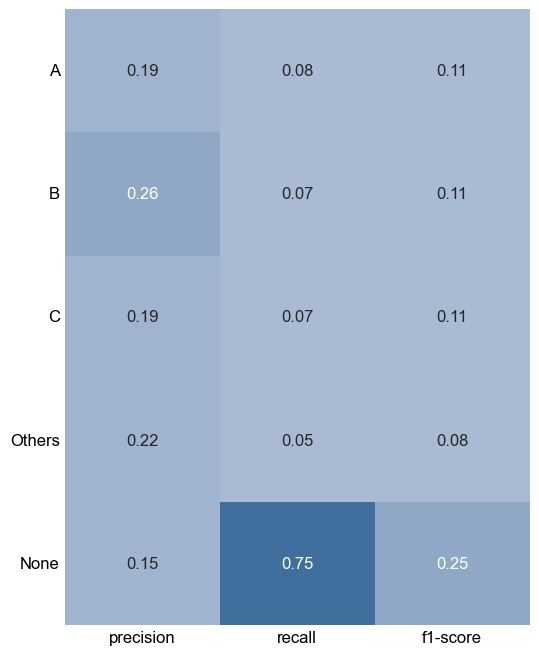

In [266]:
plt.figure(figsize=(6, 8))
sns.heatmap(report_df, annot=True, cmap=custom_cmap_blues, cbar=False, vmin=0, vmax=1,  fmt='.2f',
            annot_kws={"fontfamily": "Arial", "fontsize": 12})
#plt.xlabel('Metrics', labelpad=12, fontname='Arial', fontsize=12)
#plt.title('Classification report', fontname='Arial', fontsize=14, y=1.02)
plt.xticks(fontname='Arial', fontsize=12)
plt.yticks(fontname='Arial', fontsize=12, rotation=0)
plt.tick_params(axis='y', length=0)
plt.tick_params(axis='x', length=0)
plt.show()

##### d. Binary threshold test

In [122]:
results_binary = df_long 
results_max_score = results_binary.groupby('Text')['Score'].max() #get the highest score among 4 categories
results_final = pd.merge(results_binary, results_max_score, on=['Text', 'Score'])

results_final['Predict'] = np.where(results_final['Score'] > 0.70, 'Yes', 'None') #if max score of highest category is above 0.95, predicted label = yes
results_final['Category_New'] = np.where(results_final['Category_New'] == 'None', results_final['Category_New'], 'Yes') #all categories changed to 'yes' except none

In [123]:
report = classification_report(results_final['Category_New'], results_final['Predict'])
print(report)

              precision    recall  f1-score   support

        None       0.16      0.59      0.25       473
         Yes       0.85      0.43      0.57      2605

    accuracy                           0.45      3078
   macro avg       0.50      0.51      0.41      3078
weighted avg       0.74      0.45      0.52      3078



Based on the results of both the Glove and LegalW2V similarity tests, it appears pre-trained embeddings are able to more or less distinguish whether a certain paragraph is similar to a competition restriction definition. However, the embeddings are unable to capture the difference among the four categories.

##### e. Dimensionality reduction

In [351]:
dfm_reduced = dfm_combined(df_comb, text_doc_matrix, defs_doc_matrix)

In [352]:
dfm_reduced.to_csv("data/scores/02 sim_scores_dim_reduced_legal.csv")

Labeled data (not augmented)

In [300]:
legal_embed_nonaug = vectorizer.fit_transform(text_labels['text_clean'])
legal_dfm = doc_matrix_w2v(legal_embed_nonaug)
legal_dfm.shape

(1792, 200)

In [301]:
embed = reducer.fit_transform(legal_dfm)
text_labels["x"] = embed[:,0]
text_labels["y"] = embed[:,1]

In [304]:
text_labels.to_csv("data/03 word_embed_legal.csv")

### IV. TF-IDF with GloVe

In [102]:
vectorizer = TfidfVectorizer()

In [103]:
dfm_train = vectorizer.fit_transform(train_df_aug['text_clean'])
dfm_test = vectorizer.fit_transform(test_df['text_clean'])

print('train dfm shape: ' + str(dfm_train.shape) + ' | test dfm shape:' + str(dfm_test.shape))

train dfm shape: (3445, 3748) | test dfm shape:(708, 2099)


In [104]:
common_features = set(embed_matrix.index) & set(vectorizer.get_feature_names_out())
vocab_ids = [vectorizer.vocabulary_[x] for x in common_features]
len(common_features)

1328

In [105]:
doc_matrix_train = dfm_train[:,vocab_ids].dot(embed_matrix.loc[common_features,])
doc_matrix_train.shape

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_98263/1566701910.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  doc_matrix_train = dfm_train[:,vocab_ids].dot(embed_matrix.loc[common_features,])


(3445, 300)

In [106]:
doc_matrix_test = dfm_test[:,vocab_ids].dot(embed_matrix.loc[common_features,])
doc_matrix_test.shape

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_98263/3295480290.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  doc_matrix_test = dfm_test[:,vocab_ids].dot(embed_matrix.loc[common_features,])


(708, 300)

In [107]:
train_text, train_labels, test_text, test_labels = doc_matrix_train, train_df_aug['Category_New'], doc_matrix_test, test_df['Category_New']

In [108]:
# scale data
scaler = StandardScaler(with_mean=False)
train_text_scaled = scaler.fit_transform(train_text)
test_text_scaled = scaler.transform(test_text)

# train model and return training accuracy
clf = LogisticRegression(random_state=999, max_iter=1000).fit(train_text_scaled, train_labels)
with open('./models/logistic.pkl', 'wb') as f: pickle.dump(clf, f)

train_acc = clf.score(train_text_scaled, train_labels)

# evaluate on test data 
y_pred = clf.predict(test_text_scaled)
classification_rep = classification_report(test_labels, y_pred, zero_division=0)
test_acc = clf.score(test_text_scaled, test_labels)

# print classification report
print(' Classification Report:')
print(classification_rep)
print('Train vs Test Accuracy:')
print('Train:' + str(round(train_acc, 3)))
print('Test:' + str(round(test_acc, 3)))

 Classification Report:
              precision    recall  f1-score   support

           A       0.56      0.31      0.40       376
           B       0.15      0.31      0.20        68
           C       0.08      0.22      0.12        18
        None       0.33      0.35      0.34       225
      Others       0.03      0.10      0.04        21

    accuracy                           0.32       708
   macro avg       0.23      0.26      0.22       708
weighted avg       0.42      0.32      0.35       708

Train vs Test Accuracy:
Train:0.785
Test:0.316


In [109]:
# generate classification report
report = classification_report(test_labels, y_pred, zero_division=0, output_dict=True)

# extract precision, recall, and f1-score for each category
categories = ['A', 'B', 'C', 'Others', 'None']
metrics = ['precision', 'recall', 'f1-score']
data = []
for category in categories:
    row = []
    for metric in metrics:
        row.append(round(report[category][metric], 2))
    data.append(row)

# create dataframe
report_df = pd.DataFrame(data, columns=metrics, index=categories)

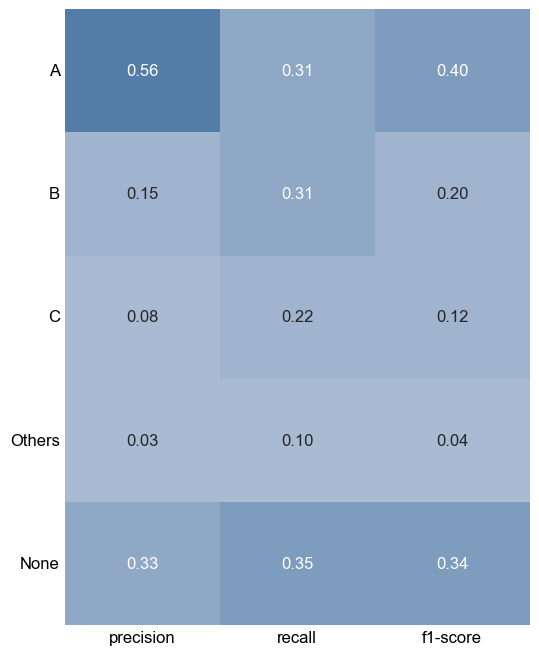

In [110]:
plt.figure(figsize=(6, 8))
sns.heatmap(report_df, annot=True, cmap=custom_cmap_blues, cbar=False, vmin=0, vmax=1,  fmt='.2f',
            annot_kws={"fontfamily": "Arial", "fontsize": 12})
#plt.xlabel('Metrics', labelpad=12, fontname='Arial', fontsize=12)
#plt.title('Classification report', fontname='Arial', fontsize=14, y=1.02)
plt.xticks(fontname='Arial', fontsize=12)
plt.yticks(fontname='Arial', fontsize=12, rotation=0)
plt.tick_params(axis='y', length=0)
plt.tick_params(axis='x', length=0)

# save the figure
save_path = os.path.join('draft', 'images', 'plot05-04.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

### V. TF-IDF with Legal Word2Vec

In [89]:
w2v_law

In [90]:
train_vectors = vectorizer.fit_transform(train_df_aug['text_clean'])
train_doc_matrix = doc_matrix_w2v(train_vectors)
train_doc_matrix.shape

(3445, 200)

In [91]:
test_vectors = vectorizer.fit_transform(test_df['text_clean'])
test_doc_matrix = doc_matrix_w2v(test_vectors)
test_doc_matrix.shape

(708, 200)

In [92]:
train_text, train_labels, test_text, test_labels = train_doc_matrix, train_df_aug['Category_New'], test_doc_matrix, test_df['Category_New']

In [93]:
# scale data
scaler = StandardScaler(with_mean=False)
train_text_scaled = scaler.fit_transform(train_text)
test_text_scaled = scaler.transform(test_text)

# train model and return training accuracy
clf = LogisticRegression(random_state=999, max_iter=1000).fit(train_text_scaled, train_labels)
with open('./models/logistic.pkl', 'wb') as f: pickle.dump(clf, f)

train_acc = clf.score(train_text_scaled, train_labels)

# evaluate on test data 
y_pred = clf.predict(test_text_scaled)
classification_rep = classification_report(test_labels, y_pred, zero_division=0)
test_acc = clf.score(test_text_scaled, test_labels)

# print classification report
print(' Classification Report:')
print(classification_rep)
print('Train vs Test Accuracy:')
print('Train:' + str(round(train_acc, 3)))
print('Test:' + str(round(test_acc, 3)))

 Classification Report:
              precision    recall  f1-score   support

           A       0.84      0.55      0.66       376
           B       0.25      0.56      0.34        68
           C       0.20      0.56      0.30        18
        None       0.81      0.66      0.73       225
      Others       0.17      0.62      0.27        21

    accuracy                           0.59       708
   macro avg       0.45      0.59      0.46       708
weighted avg       0.74      0.59      0.63       708

Train vs Test Accuracy:
Train:0.792
Test:0.588


In [94]:
# generate classification report
report = classification_report(test_labels, y_pred, zero_division=0, output_dict=True)

# extract precision, recall, and f1-score for each category
categories = ['A', 'B', 'C', 'Others', 'None']
metrics = ['precision', 'recall', 'f1-score']
data = []
for category in categories:
    row = []
    for metric in metrics:
        row.append(round(report[category][metric], 2))
    data.append(row)

# create dataframe
report_df = pd.DataFrame(data, columns=metrics, index=categories)

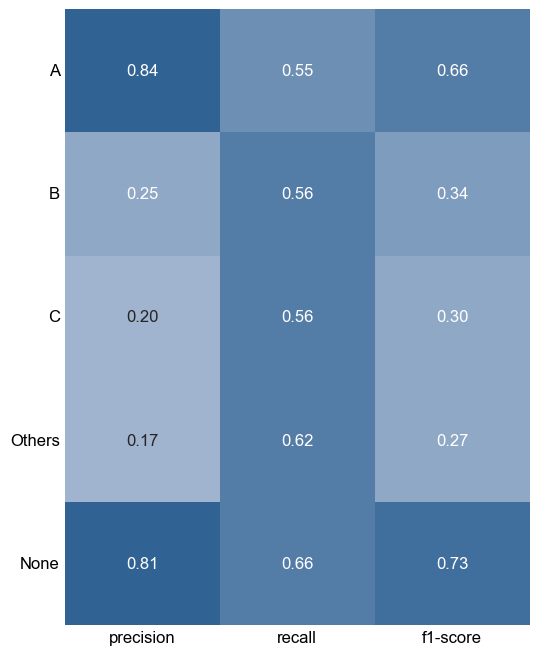

In [101]:
plt.figure(figsize=(6, 8))
sns.heatmap(report_df, annot=True, cmap=custom_cmap_blues, cbar=False, vmin=0, vmax=1,  fmt='.2f',
            annot_kws={"fontfamily": "Arial", "fontsize": 12})
#plt.xlabel('Metrics', labelpad=12, fontname='Arial', fontsize=12)
#plt.title('Classification report', fontname='Arial', fontsize=14, y=1.02)
plt.xticks(fontname='Arial', fontsize=12)
plt.yticks(fontname='Arial', fontsize=12, rotation=0)
plt.tick_params(axis='y', length=0)
plt.tick_params(axis='x', length=0)

# save the figure
save_path = os.path.join('draft', 'images', 'plot05-05.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()